# Detecting Dwarf Galaxies: The Performance & Limitations of Various Density Estimators

### Nicolas Garavito, Jennifer Kadowaki, Matt Kirby, Ben Lew, Ragadeepika Pucha

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import sys

In [2]:
sys.path.append('../code/')
import density_functions
from density_tools import density_peaks

In [3]:
font = {'size':20, 'family':'serif'}
matplotlib.rc('font', **font)

# Plan - 

- Different Density Detections on Known Dwarfs
- Comparison
- Fake Data 
- M_v VS r_h plot

In [4]:
### Nearest Density Estimator 



astroML.density_estimation.density_estimation.KNeighborsDensity

In [5]:
## reading the data
def read_data(data):
    """
    Reads the fits data   """
    leo1 = fits.open(data)
    t = leo1[1].data
    ra_leo1 = t['ra']
    dec_leo1 = t['dec']
    return ra_leo1, dec_leo1

In [9]:
## 

def overdensities(dens, sigma_min, sigma_max, xmin=0, xmax=1, ymin=0, ymax=1):
    # Defining grid
    x = np.linspace(xmin, xmax, np.shape(dens)[0])
    y = np.linspace(ymin, ymax, np.shape(dens)[1])
    X, Y = np.meshgrid(x, y)

    # Defining sigma as the standard deviation of the data
    sigma = np.std(dens.flatten())
    # Finding the median of the all the data in the field
    dens_median = np.median(dens.flatten())
    # Defining the contours range.·
    overdensities = []
    color_bar_labels = []

    for i in range(sigma_min, sigma_max+1):
        overdensities.append(dens_median + i*sigma)
        color_bar_labels.append(str(i) + '$\sigma$')
    print(color_bar_labels)
    
    return X, Y, overdensities, color_bar_labels


In [19]:
sdss_data = ['draco.fits', 'leo2.fits', 'segue.fits', 'willman1.fits']
mock_data = ['test_field.fits', 'test_field1.fits']

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(12.5,12.5))

for name in sdss_data:
    print(name)
    figure(figsize=(5,5))
    title('{}'.format(name))
    ra, dec = read_data('../data/sdss_fields/'+name)
    scatter(ra, dec, s=0.4, c='k')


draco.fits
['1$\\sigma$', '2$\\sigma$', '3$\\sigma$', '4$\\sigma$', '5$\\sigma$', '6$\\sigma$', '7$\\sigma$', '8$\\sigma$', '9$\\sigma$', '10$\\sigma$']
['1$\\sigma$', '2$\\sigma$', '3$\\sigma$', '4$\\sigma$', '5$\\sigma$', '6$\\sigma$', '7$\\sigma$', '8$\\sigma$', '9$\\sigma$', '10$\\sigma$']
['1$\\sigma$', '2$\\sigma$', '3$\\sigma$', '4$\\sigma$', '5$\\sigma$', '6$\\sigma$', '7$\\sigma$', '8$\\sigma$', '9$\\sigma$', '10$\\sigma$']
['1$\\sigma$', '2$\\sigma$', '3$\\sigma$', '4$\\sigma$', '5$\\sigma$', '6$\\sigma$', '7$\\sigma$', '8$\\sigma$', '9$\\sigma$', '10$\\sigma$']
leo2.fits
['1$\\sigma$', '2$\\sigma$', '3$\\sigma$', '4$\\sigma$', '5$\\sigma$', '6$\\sigma$', '7$\\sigma$', '8$\\sigma$', '9$\\sigma$', '10$\\sigma$']
['1$\\sigma$', '2$\\sigma$', '3$\\sigma$', '4$\\sigma$', '5$\\sigma$', '6$\\sigma$', '7$\\sigma$', '8$\\sigma$', '9$\\sigma$', '10$\\sigma$']
['1$\\sigma$', '2$\\sigma$', '3$\\sigma$', '4$\\sigma$', '5$\\sigma$', '6$\\sigma$', '7$\\sigma$', '8$\\sigma$', '9$\\sigma$', 

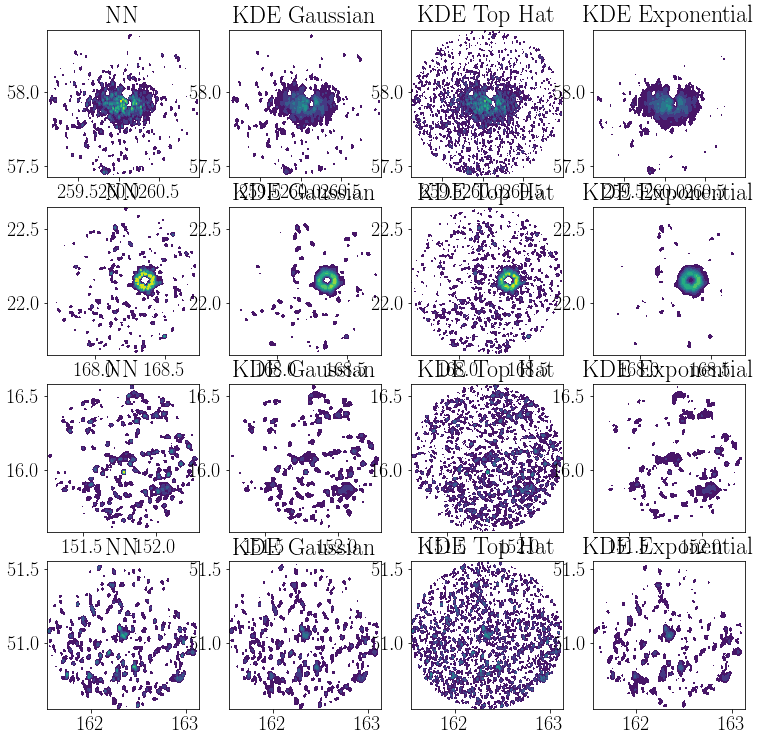

In [20]:
#figure = figsize(10, 10)
## To do 
## revere RA
## colorbar
## fix titles
## repeat for test and scatter plots
fig, axes = plt.subplots(4, 4, figsize=(12.5,12.5))
k=0
for name in sdss_data:
    print(name)
    ra, dec = read_data('../data/sdss_fields/'+name)
    dens_field_NN = density_functions.NN_bayesian_density(ra, dec, 20, 500)
    dens_field_KDE_gaussian = density_functions.KDE(ra,dec, kernel = 'gaussian')
    dens_field_KDE_th = density_functions.KDE(ra,dec, kernel = 'tophat')
    dens_field_KDE_exponential = density_functions.KDE(ra,dec, kernel = 'exponential')
    
    
    X_NN, Y_NN, overdens_NN, colorbar_NN = overdensities(dens_field_NN, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_gaussian, Y_KDE_gaussian, overdens_KDE_gaussian, colorbar_KDE_exp = overdensities(dens_field_KDE_gaussian, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_th, Y_KDE_th, overdens_KDE_th, colorbar_ = overdensities(dens_field_KDE_th, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))
    X_KDE_exp, Y_KDE_exp, overdens_KDE_exp, colorbar_NN = overdensities(dens_field_KDE_exponential, 1, 10, xmin=min(ra), xmax=max(ra), ymin=min(dec), ymax=max(dec))

    axes[0][0].set_title('NN')
    axes[0][1].set_title('KDE Gaussian')
    axes[0][2].set_title('KDE Top Hat')
    axes[0][3].set_title('KDE Exponential')

    axes[k][0].contourf(X_NN, Y_NN, dens_field_NN, overdens_NN)
    axes[k][1].contourf(X_KDE_gaussian, Y_KDE_gaussian, dens_field_KDE_gaussian, overdens_KDE_gaussian)
    axes[k][2].contourf(X_KDE_th, Y_KDE_th, dens_field_KDE_th, overdens_KDE_th)
    axes[k][3].contourf(X_KDE_exp, Y_KDE_exp, dens_field_KDE_exponential, overdens_KDE_exp)

    k+=1

    #xlim(min(ra), max(ra))
    #k+=1